## Global properties 1

In [1]:
using PyCall
using Distributions
using Statistics
using DataFrames

using Distances
using Random , Printf

rootdir = "/home/stephane/Science/GAIA"

push!(LOAD_PATH,"$rootdir/master/src")
using GaiaClustering

import PyPlot , CSV

wdir    = "$rootdir/products"
votdir  = "$rootdir/products/votable"
ocdir   = "$rootdir/products/oc"

cd(wdir)

In [2]:
## compute global properties

function compute_globalparams(df, dfout, votname)
    ram= median(df[:ra])
    decm= median(df[:dec])
    lm= median(df[:l])
    bm= median(df[:b])
    pmram= median(df[:pmra])
    pmdec= median(df[:pmdec])
    distm= median(df[:distance])
    Xm= median(df[:X]) 
    Ym= median(df[:Y])
    Zm= median(df[:Z])
    vbm= median(df[:vb])
    vlm= median(df[:vl])
    vrm= radialVelocity(df[:vrad])

    Xgalm, Ygalm , Zgalm= _galXYZ(lm , bm , distm) 
    uvw= _galUVW(ram, decm, distm, pmram, pmdecm, vrm)
    
    push!(dfout, (votname,ram, decm, lm, bm, distm, Xm, Ym, Zm, Xgalm, Ygalm, Zgalm, vlm, vbm, vrm,
            uvw[1],uvw[2],uvw[3]))
    return(0)
    
end

compute_globalparams (generic function with 1 method)

In [3]:
## median of radial velocity
function radialVelocity(vrad)
    v=[]
    for vel in vrad
        if !isnan(vel)
            push!(v,vel)
        end
    end
    
    if length(v)==0
        push!(v,-999)
    end
    return(mean(v))
end

## Compute the X,Y,Z galactic coordinates (centered on the Galactic Center)
## See Ellsworth-Bowers et al. (2013)
## Rgal was updated from Anderson et al. (2018)

function _galXYZ(l,b,distance)
    Rgal= 8.34e3
    zsun= 25
    θ= asin(zsun/Rgal)
    
    xg= Rgal*cos(θ)-distance*(cosd(l)cosd(b)cos(θ)+sind(b)sin(θ))
    yg= -distance*sind(l)cosd(b)
    zg= Rgal*sin(θ)-distance*(cosd(l)cosd(b)sin(θ)-sind(b)cos(θ))
    
    return(xg,yg,zg)
end


### compute galactic U V W from idlastro gal_uvw.pro
##
## ra, dec: degrees
## distance; pc
## pmra,pmdec: milliarcsec/yr
## vrad: km/s

## UVW: km/s
#      U - Velocity (km/s) positive toward the Galactic *anti*center
#      V - Velocity (km/s) positive in the direction of Galactic rotation
#      W - Velocity (km/s) positive toward the North Galactic Pole

function _galUVW(ra, dec, distance, pmra, pmdec, vrad ; LSR_vel=[-8.5 ; 13.38 ; 6.49])
    k = 4.74047     #Equivalent of 1 A.U/yr in km/s   
    
    T=  [0.0548756   0.873437  0.483835 ;
          0.494109   -0.44483   0.746982 ;
         -0.867666   -0.198076  0.455984]

    A1= [ cosd(ra) sind(ra) 0 ; sind(ra) -cosd(ra) 0 ; 0 0 -1]
    A2= [ cosd(dec) 0 -sind(dec) ; 0 -1 0 ; -sind(dec) 0 -cosd(dec)]
    vec1 = vrad
    vec2 = k*pmra*1e-3*distance
    vec3 = k*pmdec*1e-3*distance
    v= [vec1 ; vec2 ; vec3]
    
    uvw= T*A1*A2*v + LSR_vel
         
    return(uvw)
end

galUVW (generic function with 0 methods)

In [4]:
## Main loop
##

macro main(paramfile)
    let
        println("## Starting main loop..")
        spl= CSV.read(paramfile)
        println("## $paramfile read..") 
        s=size(spl)
        
        dfout= DataFrame(votname=String[], ram= Float64[], decm= Float64[], lm= Float64[], bm= Float64[], 
            distm= Float64[], Xm= Float64[], Ym= Float64[], Zm= Float64[], Xgalm= Float64[], 
            Ygalm= Float64[], Zgalm= Float64[], vlm= Float64[], vbm= Float64[], vrm= Float64[] ,
            U= Float64[],V= Float64[], W= Float64[])
        
        for i in 1:s[1]
            votname = spl[:votname][i]
            println("## Starting with $votname")
            
            ocfile= @sprintf("%s/%s-oc.csv",ocdir,votname[1:end-4])
            @printf("### oc file: %s \n",ocfile)
            
            df= CSV.read(ocfile,delim=";")
            compute_globalparams(df, dfout, votname)
        end
        
        fileout= @sprintf("%s-SCglobal.csv",paramfile[1:end-4])
        CSV.write(fileout, dfout, delim=";")
        println("## $fileout written...")
        return(fileout)
    end
end

@main (macro with 1 method)

In [5]:
fileres= @main("finalSample_metric0.01.csv")

## Starting main loop..
## finalSample_metric0.01.csv read..
## Starting with Alessi 1-2.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 1-2.1deg-oc.csv 
## Starting with Alessi 12-2.4deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 12-2.4deg-oc.csv 
## Starting with Alessi 13-15.9deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 13-15.9deg-oc.csv 
## Starting with Alessi 20-1.5deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 20-1.5deg-oc.csv 
## Starting with Alessi 21-1.6deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 21-1.6deg-oc.csv 
## Starting with Alessi 2-1.7deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 2-1.7deg-oc.csv 
## Starting with Alessi 3-2.2deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 3-2.2deg-oc.csv 
## Starting with Alessi 5-1.8deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Alessi 5-1.8deg-oc.csv 
## Starting with 

## Starting with Collinder 419-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Collinder 419-1.0deg-oc.csv 
## Starting with Collinder 421-1.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Collinder 421-1.1deg-oc.csv 
## Starting with Collinder 463-2.5deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Collinder 463-2.5deg-oc.csv 
## Starting with Collinder 65-7.5deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Collinder 65-7.5deg-oc.csv 
## Starting with Collinder 69-2.7deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Collinder 69-2.7deg-oc.csv 
## Starting with Collinder 70-4.4deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Collinder 70-4.4deg-oc.csv 
## Starting with Cyg OB2-2.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Cyg OB2-2.1deg-oc.csv 
## Starting with Czernik 11-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Czernik 11-1.0deg-oc.csv 
## Starting with Czernik 44-1.0d

## Starting with FSR 1727-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/FSR 1727-1.0deg-oc.csv 
## Starting with FSR 1728-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/FSR 1728-1.0deg-oc.csv 
## Starting with FSR 1729-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/FSR 1729-1.0deg-oc.csv 
## Starting with FSR 1739-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/FSR 1739-1.0deg-oc.csv 
## Starting with FSR 1744-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/FSR 1744-1.0deg-oc.csv 
## Starting with FSR 1750-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/FSR 1750-1.0deg-oc.csv 
## Starting with Haffner 13-1.6deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Haffner 13-1.6deg-oc.csv 
## Starting with Haffner 13-1.6deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Haffner 13-1.6deg-oc.csv 
## Starting with Haffner 13-1.6deg.vot
### oc file: /home/stephane/Science/GAIA/

## Starting with Lynga 1-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Lynga 1-1.0deg-oc.csv 
## Starting with Lynga 2-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Lynga 2-1.0deg-oc.csv 
## Starting with Lynga 4-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Lynga 4-1.0deg-oc.csv 
## Starting with Melotte 101-1.2deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Melotte 101-1.2deg-oc.csv 
## Starting with Melotte 111-4.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Melotte 111-4.1deg-oc.csv 
## Starting with Melotte 20-5.5deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Melotte 20-5.5deg-oc.csv 
## Starting with Melotte 22-6.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Melotte 22-6.0deg-oc.csv 
## Starting with Morgan 8-1.2deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Morgan 8-1.2deg-oc.csv 
## Starting with MWSC 5309-1.0deg.vot
### oc file: /home/stephane/Science/

## Starting with NGC 3572-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 3572-1.0deg-oc.csv 
## Starting with NGC 3680-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 3680-1.0deg-oc.csv 
## Starting with NGC 381-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 381-1.0deg-oc.csv 
## Starting with NGC 4103-1.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 4103-1.1deg-oc.csv 
## Starting with NGC 433-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 433-1.0deg-oc.csv 
## Starting with NGC 4609-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 4609-1.0deg-oc.csv 
## Starting with NGC 4852-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 4852-1.0deg-oc.csv 
## Starting with NGC 5269-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NGC 5269-1.0deg-oc.csv 
## Starting with NGC 5281-1.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/NG

## Starting with Ruprecht 18-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Ruprecht 18-1.0deg-oc.csv 
## Starting with Ruprecht 24-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Ruprecht 24-1.0deg-oc.csv 
## Starting with Ruprecht 26-1.1deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Ruprecht 26-1.1deg-oc.csv 
## Starting with Ruprecht 64-2.2deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Ruprecht 64-2.2deg-oc.csv 
## Starting with Ruprecht 65-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Ruprecht 65-1.0deg-oc.csv 
## Starting with Ruprecht 67-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Ruprecht 67-1.0deg-oc.csv 
## Starting with Ruprecht 78-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Ruprecht 78-1.0deg-oc.csv 
## Starting with Ruprecht 91-1.0deg.vot
### oc file: /home/stephane/Science/GAIA/products/oc/Ruprecht 91-1.0deg-oc.csv 
## Starting with Ruprecht 96-1.0deg.vot


"finalSample_metric0.01-SCglobal.csv"

In [6]:
## plots of the sample properties
df= CSV.read(fileres, delim=";")

,votname,ram,decm,lm,bm,distm,Xm,Ym,Zm,Xgalm,Ygalm,Zgalm,vlm,vbm,vrm
,String⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,Alessi 1-2.1deg.vot,12.389,50.1866,122.626,-12.6708,466.936,466.9,-5.10677,4.85472,8585.89,-383.68,-76.6856,16.375,-6.87887,-5.93845
2,Alessi 12-2.4deg.vot,310.866,23.7858,67.4408,-11.4671,544.766,544.638,0.53147,-1.01656,8135.47,-493.04,-83.916,-2.89748,-16.2117,5.2948
3,Alessi 13-15.9deg.vot,51.7494,-35.9102,237.665,-55.9141,104.32,104.246,-1.75495,-3.81938,8371.49,49.399,-61.3037,1.09946,18.0723,16.8763
4,Alessi 20-1.5deg.vot,2.54594,58.6922,117.591,-3.74567,432.505,432.44,-0.570861,-0.365765,8539.94,-382.5,-2.65528,15.6493,-7.67239,-5.10956
5,Alessi 21-1.6deg.vot,107.648,-9.3955,223.441,-0.0506966,570.626,570.597,0.631322,-1.026,8754.28,392.366,25.7371,-13.1522,-10.0216,41.8898
6,Alessi 2-1.7deg.vot,71.5686,55.1563,152.353,6.3323,627.918,627.873,0.848609,-0.340607,8892.58,-289.594,95.9129,0.701823,-4.09883,-10.6923
7,Alessi 3-2.2deg.vot,109.139,-46.3095,257.626,-15.2509,281.242,281.225,-0.990263,0.443466,8398.33,265.035,-48.8051,-19.7745,-5.70257,2.14782
8,Alessi 5-1.8deg.vot,160.904,-61.1041,288.103,-1.9807,399.135,399.106,-0.123598,0.229736,8216.06,379.151,10.8333,-27.913,-9.44217,9.96882
9,Alessi 62-1.4deg.vot,283.993,21.6084,52.8114,8.69209,627.901,627.896,-0.139446,-0.46249,7964.51,-494.472,118.766,-2.55261,-2.34809,10.6799


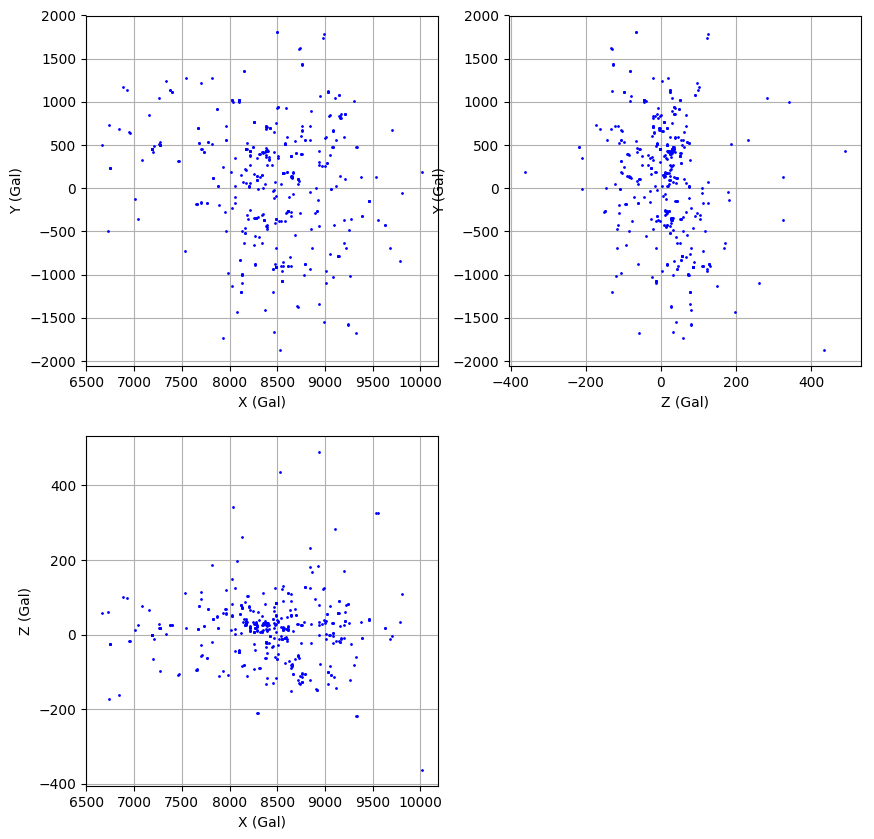

In [7]:
fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.plot(df.Xgalm,df.Ygalm,"ob", markersize = 1)
#ax.set_xlim([1.0,4.])
#ax.set_ylim([1.0,4.])
PyPlot.xlabel("X (Gal)")
PyPlot.ylabel("Y (Gal)")

ax= PyPlot.subplot(222)
PyPlot.grid("on")
PyPlot.plot(df.Zgalm,df.Ygalm,"ob", markersize = 1)
#ax.set_xlim([1.0,4.])
#ax.set_ylim([1.0,4.])
PyPlot.xlabel("Z (Gal)")
PyPlot.ylabel("Y (Gal)")

ax= PyPlot.subplot(223)
PyPlot.grid("on")
PyPlot.plot(df.Xgalm,df.Zgalm,"ob", markersize = 1)
#ax.set_xlim([1.0,4.])
#ax.set_ylim([1.0,4.])
PyPlot.xlabel("X (Gal)")
PyPlot.ylabel("Z (Gal)")

PyPlot.show()


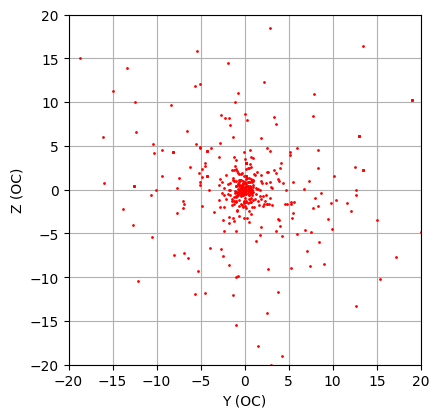

In [8]:
fig= PyPlot.figure(figsize=(10,10))

ax= PyPlot.subplot(221)
PyPlot.grid("on")
PyPlot.plot(df.Ym,df.Zm,"or", markersize = 1)
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
PyPlot.xlabel("Y (OC)")
PyPlot.ylabel("Z (OC)")

PyPlot.show()